In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [15]:
! cp kaggle.json ~/.kaggle

In [16]:
! chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.08G/3.10G [00:32<00:00, 139MB/s]
100% 3.10G/3.10G [00:32<00:00, 102MB/s]


In [18]:
!unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

# Import libraries

In [20]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

# Read our data

In [21]:
breast_img = glob.glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/content/IDC_regular_ps50_idx5/8980/0/8980_idx5_x1551_y901_class0.png
/content/IDC_regular_ps50_idx5/8980/0/8980_idx5_x851_y1651_class0.png
/content/IDC_regular_ps50_idx5/8980/0/8980_idx5_x2301_y1951_class0.png


In [22]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)

- We want split our data to positive and negative IDC
- Each patch’s file name is in specific format :
     - example :10253idx5x1351y1101class0.png 

In [23]:
len(N_IDC)

198738

In [24]:
len(P_IDC)

78786

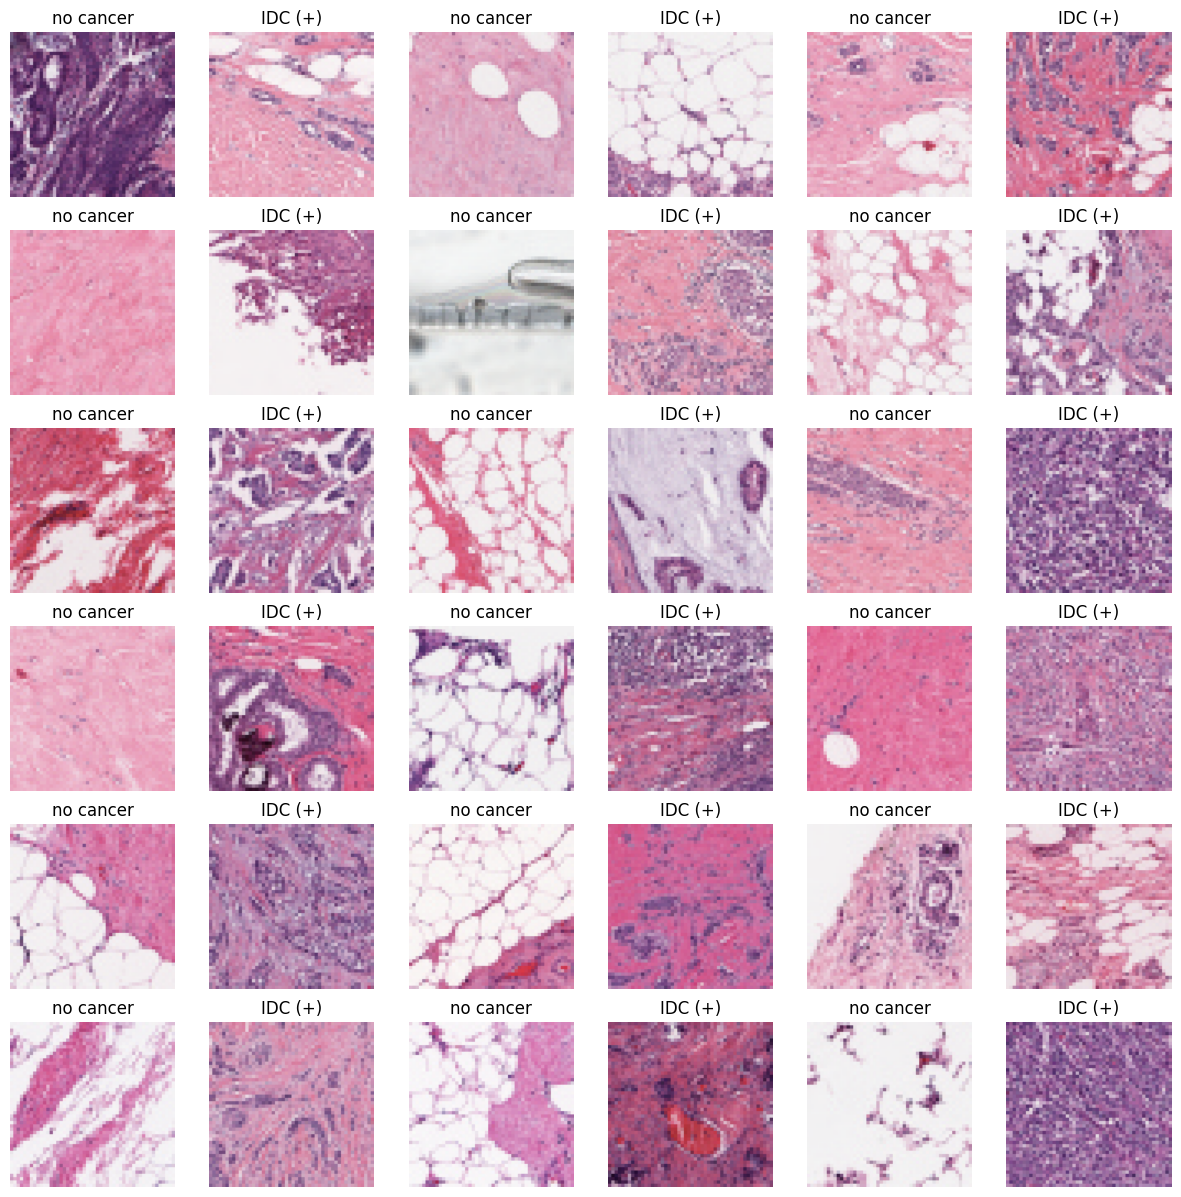

In [25]:
import keras.utils as image
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

# Handling images

In [26]:
non_img_arr = []
can_img_arr = []

for img in N_IDC:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [27]:
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)


- Identify labels [y] and images [X] 

In [28]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 277524
Number of IDC(-) Images: 264847
Number of IDC(+) Images: 12677
Image shape (Width, Height, Channels): (50, 50, 3)


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (194266, 50, 50, 3)
Testing Data Shape: (83258, 50, 50, 3)


In [30]:
# Reduce Sample Size for allocating memory Problems in kaggle 

X_train = X_train[0:50000] 
Y_train = Y_train[0:50000] 
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000] 

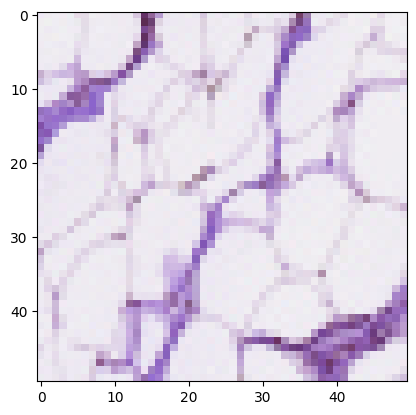

In [31]:
plt.imshow(X_train[0])

In [32]:
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

# Buliding CNN architecture

In [33]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

In [34]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                        

In [36]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 11, batch_size = 35)

Epoch 1/11
1429/1429 [==============================] - 1088s 758ms/step - loss: 0.1608 - accuracy: 0.9549 - val_loss: 0.1383 - val_accuracy: 0.9529
Epoch 2/11
1429/1429 [==============================] - 1068s 748ms/step - loss: 0.1384 - accuracy: 0.9554 - val_loss: 0.1388 - val_accuracy: 0.9529
Epoch 3/11
1429/1429 [==============================] - 1080s 756ms/step - loss: 0.1336 - accuracy: 0.9554 - val_loss: 0.1430 - val_accuracy: 0.9529
Epoch 4/11
1429/1429 [==============================] - 1098s 768ms/step - loss: 0.1293 - accuracy: 0.9554 - val_loss: 0.1370 - val_accuracy: 0.9529
Epoch 5/11
1429/1429 [==============================] - 1104s 773ms/step - loss: 0.1265 - accuracy: 0.9555 - val_loss: 0.1392 - val_accuracy: 0.9529
Epoch 6/11
1429/1429 [==============================] - 1096s 766ms/step - loss: 0.1225 - accuracy: 0.9560 - val_loss: 0.1403 - val_accuracy: 0.9541
Epoch 7/11
1429/1429 [==============================] - 1085s 759ms/step - loss: 0.1185 - accuracy: 0.9565

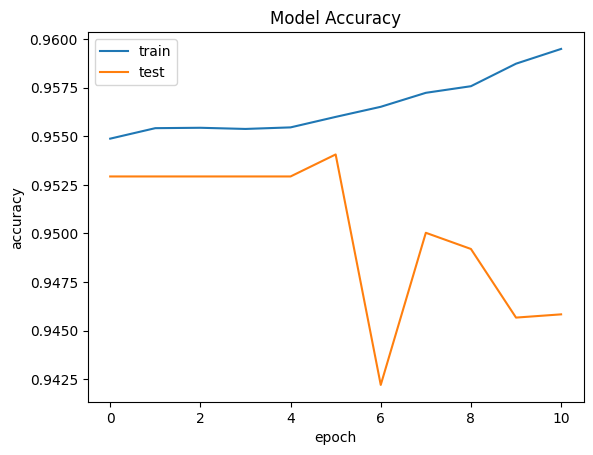

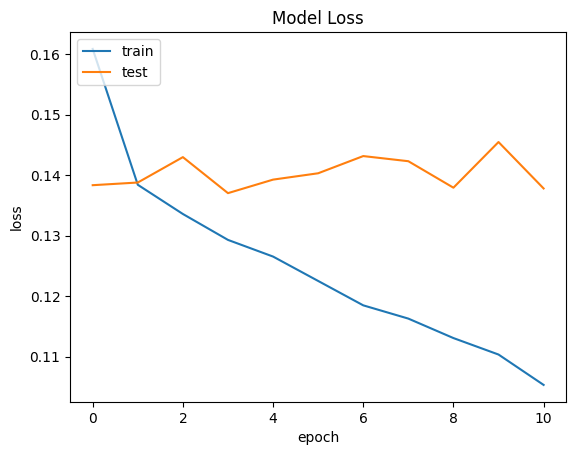

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

938/938 [==============================] - 123s 130ms/step


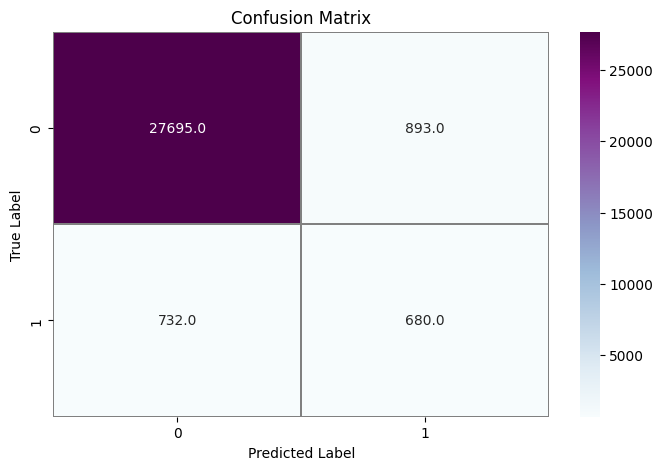

In [38]:

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

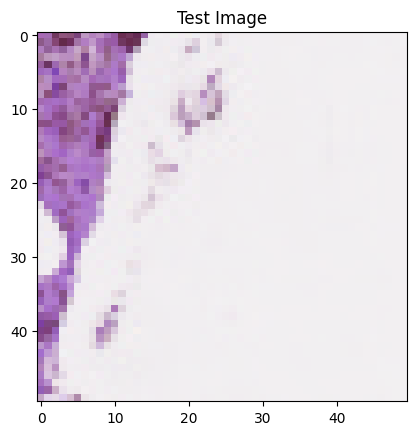

In [39]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
    
index = 90
img_plot(X_test, index)

In [40]:
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)

1/1 [==============================] - 0s 54ms/step
Predicted Value using  cnn model 0
True Value 0
